## 利用剪枝的模型抽取图像

In [2]:
import numpy as np
import sys
import time

import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../data/')
from resnet import resnet
from preact_resnet import PreActResNet18
from load_cifar import load_cifar
from load_olivetti import load_olivetti

In [3]:
os.listdir('ckpts/')

['cifar_cap_res5_0.1_model.ckpt']

In [4]:
# 加载数据
def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    return X_train, y_train, X_test

def load_data(name='cifar'):
    if name == 'cifar':
        X_train, y_train, X_test, y_test = load_cifar(10)
        X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
        X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
        X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
        X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
    else:
        X_train, y_train, X_test, y_test = load_olivetti()
    return X_train, y_train, X_test, y_test

def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])

In [5]:
def data_to_loader(x, y, size=512):
    x_data = torch.from_numpy(x)
    y_data = torch.from_numpy(y).long()
    loader = DataLoader(dataset=TensorDataset(x_data, y_data), 
                          batch_size=size, 
                          shuffle=False, 
                          num_workers=2)
    return loader

In [6]:
def mal_data_synthesis(train_x, num_targets=10, precision=4):
    # synthesize malicious images to encode secrets
    # for CIFAR, use 2 data points to encode one approximate 4-bit pixel
    # thus divide the number of targets by 2
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:  # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            # get the 4-bit approximation of 8-bit pixel
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            # use 2 data points to encode p
            # e.g. pixel=15, use (x1, 7), (x2, 8) to encode
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                # initialize a empty image
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                # simple & naive deterministic value for two pixel
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets


In [7]:
X_train, y_train, X_test, y_test = load_data(name='cifar')
X_mal, y_mal, mal_n = mal_data_synthesis(X_train, num_targets=8)
X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
train_loader = data_to_loader(X_train, y_train)
test_loader = data_to_loader(X_test, y_test)
mal_loader = data_to_loader(X_mal, y_mal)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
network = resnet(num_classes=10).to(device)
path = 'ckpts/cifar_cap_res5_0.1_model.ckpt'
network.load_state_dict(torch.load(path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [9]:
np_clean_list = []
network.eval()
with torch.no_grad():
    for i, batch in enumerate(train_loader):
        inputs, _ = batch
        outs = network.inner(inputs.to('cuda')).cpu().data.numpy()
        np_clean_list.extend(list(outs))
np_clean_list = np.array(np_clean_list)
print(np_clean_list.shape)

(50000, 64)


In [10]:
cl_means = np_clean_list.mean(axis=0)
seq_sort_clean = np.argsort(cl_means)
seq_sort_clean

array([ 5,  3, 58,  7, 22, 10, 11, 18,  4, 12, 31, 45, 38, 49, 30, 42, 34,
       14, 54, 39, 13,  6, 28, 52, 24, 17, 33, 40, 61, 56, 21, 15,  1, 29,
       27, 35,  2, 46, 20, 57, 19, 48, 23, 32, 55, 44,  9, 36, 16, 26, 60,
       41, 59, 25, 50,  0,  8, 47, 51, 63, 43, 62, 53, 37])

In [11]:
import copy
param_values = torch.load('ckpts/cifar_cap_res5_0.1_model.ckpt')
new_params = copy.deepcopy(param_values)

In [24]:
# 剪枝
neurons = 40

new_params = copy.deepcopy(param_values)
new_params['fc_out.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([10, neurons])).float().cuda()
network.load_state_dict(new_params)

out_list = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        inputs, _ = batch
        network.eval()
        outputs = network(inputs.to('cuda')).max(1)[1].cpu().data.numpy()
        out_list.extend(list(outputs))
        
np_out_list = np.array(out_list)


In [25]:
def cap_reconstruct(net, loader):
    res = []
    net.eval()
    for i, data in enumerate(loader):
        x, y = data
        x = x.to(device)
        pred = net(x)
        res.append(pred.max(1)[1])
    res = torch.cat(res)
    res = res.reshape(-1, 2).sum(1).reshape(-1,32,32)*(2**4)
    return res

In [26]:
x = cap_reconstruct(network, mal_loader)

In [27]:
import matplotlib.pyplot as plt

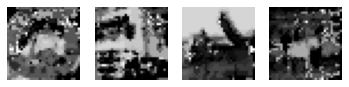

In [28]:
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x[i].cpu(), cmap='gray')
    plt.axis('off')